In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv("./../data/store_sales_over_time.csv", parse_dates=["date"])
data.head()

# Aggregate sales by store and date
store_sales = data.groupby(["store_nbr", "date"])['sales'].sum().reset_index()
# Pivot the data to get stores as rows and dates as columns
store_sales_pivot = store_sales.pivot(index="store_nbr", columns="date", values="sales").fillna(0)
# Inspect the pivoted data
store_sales_pivot.head()

scaler = StandardScaler()
store_sales_scaled = scaler.fit_transform(store_sales_pivot)

store_sales.head()

,store_nbr,date,sales
0,1,2013-01-01,0.000000
1,1,2013-01-02,7417.148000
2,1,2013-01-03,5873.244001
3,1,2013-01-04,5919.879001
4,1,2013-01-05,6318.785010


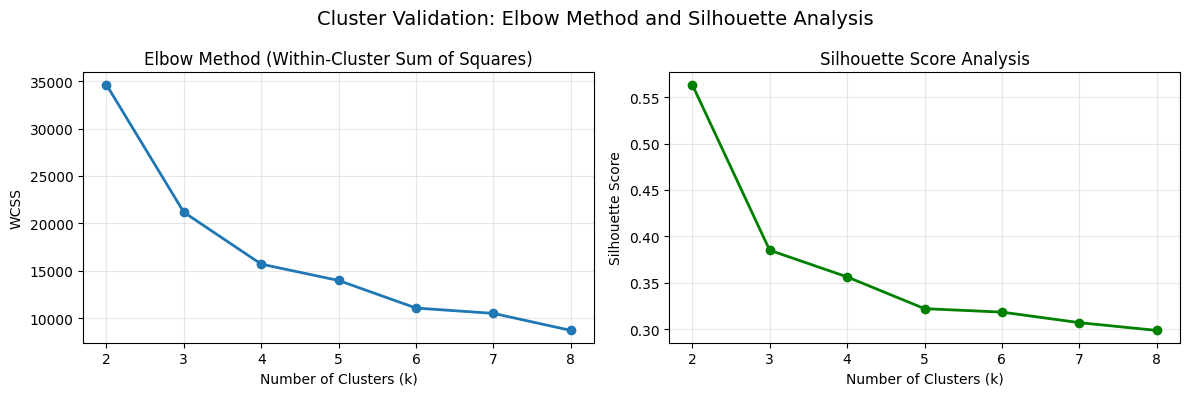

In [3]:
k_values = range(2, 9)

inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(store_sales_scaled)

    inertia.append(kmeans.inertia_)
    silhouette_scores.append(
        silhouette_score(store_sales_scaled, labels)
    )

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Elbow method (WCSS)
axes[0].plot(k_values, inertia, marker="o", linewidth=2)
axes[0].set_title("Elbow Method (Within-Cluster Sum of Squares)")
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("WCSS")
axes[0].grid(alpha=0.3)

# Silhouette score
axes[1].plot(k_values, silhouette_scores, marker="o", linewidth=2, color="green")
axes[1].set_title("Silhouette Score Analysis")
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(alpha=0.3)

plt.suptitle("Cluster Validation: Elbow Method and Silhouette Analysis", fontsize=14)
plt.tight_layout()
plt.savefig("./figures/sales_k_opt.png")
plt.show()


In [4]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(store_sales_scaled)
store_sales_pivot['cluster'] = kmeans.labels_
store_sales_pivot[['cluster']].head()

date,cluster
store_nbr,
1,0
2,1
3,2
4,1
5,0


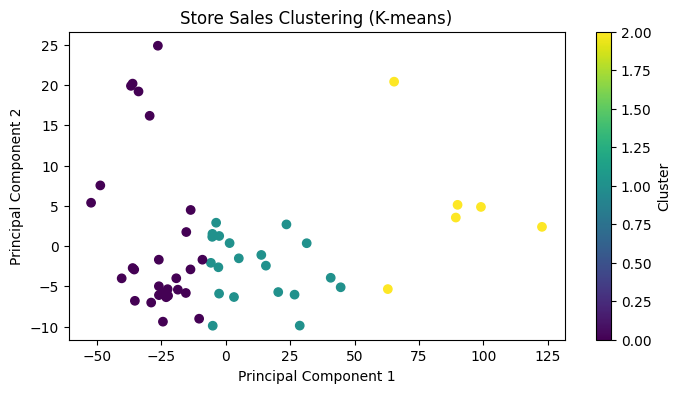

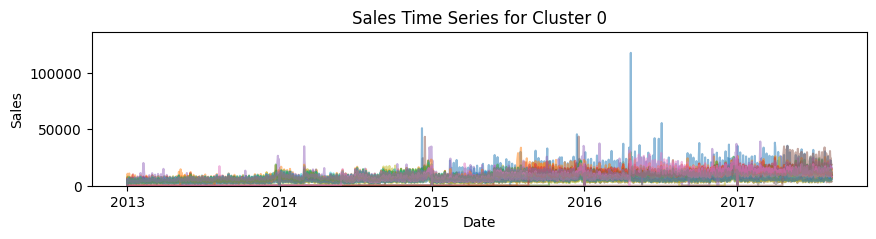

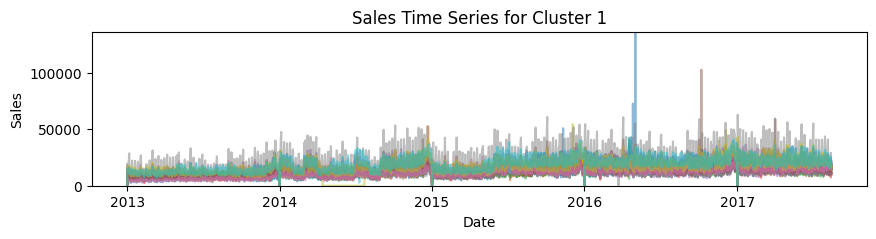

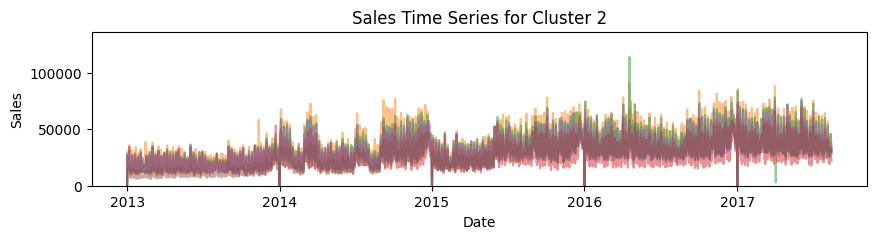

In [10]:
pca = PCA(n_components=2)
store_sales_pca = pca.fit_transform(store_sales_scaled)

plt.figure(figsize=(8, 4))
plt.scatter(store_sales_pca[:, 0], store_sales_pca[:, 1], c=kmeans.labels_, cmap="viridis")
plt.title("Store Sales Clustering (K-means)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.savefig("./figures/sales_cluster.png")
plt.show()

# ===== Page 10 =====
# Interpreting the Clusters

## Step 6: Interpreting the Clusters
global_min = store_sales_pivot.drop(columns=['cluster']).min().min()
global_max = store_sales_pivot.drop(columns=['cluster']).max().max()

for cluster_id in range(3):
    cluster_stores = store_sales_pivot[store_sales_pivot['cluster'] == cluster_id]
    plt.figure(figsize=(10, 2))
    for store in cluster_stores.index:
        plt.plot(store_sales_pivot.drop(columns=['cluster']).columns,
                 store_sales_pivot.drop(columns=['cluster']).loc[store], alpha=0.5)
    plt.ylim(global_min, global_max)
    plt.title(f"Sales Time Series for Cluster {cluster_id}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.show()

In [11]:
# Store-level summary statistics
store_summary = pd.DataFrame({
    "mean_sales": store_sales_pivot.drop(columns="cluster").mean(axis=1),
    "std_sales": store_sales_pivot.drop(columns="cluster").std(axis=1),
    "min_sales": store_sales_pivot.drop(columns="cluster").min(axis=1),
    "max_sales": store_sales_pivot.drop(columns="cluster").max(axis=1),
    "cluster": store_sales_pivot["cluster"]
})

cluster_profile = (
    store_summary
    .groupby("cluster")
    .agg(
        n_stores=("mean_sales", "count"),
        avg_sales=("mean_sales", "mean"),
        std_sales=("mean_sales", "std"),
        min_sales=("mean_sales", "min"),
        max_sales=("mean_sales", "max"),
        avg_variability=("std_sales", "mean")
    )
)

# Coefficient of variation
cluster_profile["cv_sales"] = (
    cluster_profile["avg_variability"] / cluster_profile["avg_sales"]
)

cluster_profile = cluster_profile.round(2)
cluster_profile

,n_stores,avg_sales,std_sales,min_sales,max_sales,avg_variability,cv_sales
cluster,,,,,,,
0,28,6432.33,1999.04,1601.05,9733.78,3572.91,0.56
1,20,13866.27,3362.09,10148.89,21337.96,5305.47,0.38
2,6,30020.98,4400.64,24878.90,36869.09,12538.40,0.42
